In [1]:
#!/usr/bin/env python3
"""
Create two dictionaries:
• `all_tle_dict`   – every TLE read from the cached file (no filters)
• `filtered_tle_dict` – same set but
    · Starlink / OneWeb removed
    · epochs limited to 1–30 May 2024
    · eccentricity ≤ 0.01
"""
from datetime import datetime, timedelta, timezone
from collections import defaultdict
import math, csv, pathlib

mu = 398600.4418
M, A, Cd = 1.0, 1.0, 2.2

# ---------------------------------------------------------------------
# paths
# ---------------------------------------------------------------------
# path = "/Users/charlesc/Documents/GitHub/POD-Density-Inversion/source/tools/tle_archive/tle_data_2024-05-01_to_2024-05-30.tle"
path = pathlib.Path("/Users/charlesc/Documents/GitHub/POD-Density-Inversion/source/tools/tle_archive/tle_data_2024-05-08_to_2024-05-15.tle")
satcat_path = pathlib.Path("/Users/charlesc/Documents/GitHub/POD-Density-Inversion/source/tools/tle_archive/celestrak_satcat.csv")

# ---------------------------------------------------------------------
# helper functions
# ---------------------------------------------------------------------

def mm(line2):      # mean motion (rev/day)
    return float(line2[52:63])

def mm_dot(line1):  # mean‑motion derivative (rev/day²)
    return float(line1[33:43])

def epoch(line1):   # returns aware‑UTC datetime
    e = line1[18:32]
    return (
        datetime(2000 + int(e[:2]), 1, 1) + timedelta(days=float(e[2:]) - 1)
    ).replace(tzinfo=timezone.utc)

# ---------------------------------------------------------------------
# 1. read cached TLE file → all_tle_dict
# ---------------------------------------------------------------------
all_tle_dict = defaultdict(list)
with open(path) as f:
    lines = [ln.rstrip() for ln in f if ln.strip()]

for i in range(0, len(lines), 2):
    l1, l2 = lines[i], lines[i + 1]
    sat = l1[2:7]
    t = epoch(l1)
    N = mm(l2)
    Ndot = mm_dot(l1)
    n = N * 2 * math.pi / 86400
    ndot = Ndot * 2 * math.pi / 86400 ** 2
    a = (mu / n ** 2) ** (1 / 3)
    ecc = float("0." + l2[26:33])
    v = math.sqrt(mu / a)
    rho = (2 * M * ndot) / (3 * Cd * A * n * v)
    all_tle_dict[sat].append((t, n, ndot, a, ecc, v, rho))

print(f"Loaded TLEs for {len(all_tle_dict)} unique NORAD IDs (unfiltered)")

# ---------------------------------------------------------------------
# 2. load Celestrak SATCAT → names dict
# ---------------------------------------------------------------------
names = {}
with satcat_path.open() as f:
    for row in csv.DictReader(f):
        names[row["NORAD_CAT_ID"].lstrip("0")] = row["OBJECT_NAME"].upper()

# ---------------------------------------------------------------------
# 3. build filtered_tle_dict with requested criteria
# ---------------------------------------------------------------------
start_date = datetime(2024, 5, 8, tzinfo=timezone.utc).date()
end_date   = datetime(2024, 5, 15, tzinfo=timezone.utc).date()
block      = ("STARLINK", "ONEWEB")

filtered_tle_dict = {}
for sat, recs in all_tle_dict.items():
    if any(b in names.get(sat, "") for b in block):
        continue  # skip Starlink/OneWeb
    in_range = [r for r in recs if start_date <= r[0].date() <= end_date and r[4] <= 0.01]
    if in_range:
        filtered_tle_dict[sat] = in_range

print(f"After all filters: {len(filtered_tle_dict)} unique NORAD IDs")



Loaded TLEs for 27589 unique NORAD IDs (unfiltered)
After all filters: 13558 unique NORAD IDs


In [4]:
# 1. select by date & eccentricity, compute decay rate and initial altitude
start_date = datetime(2024, 5, 10, tzinfo=timezone.utc).date()
end_date   = datetime(2024, 5, 13, tzinfo=timezone.utc).date()
decay_rates = {}   # sat → (decay_rate_km_per_day, initial_alt_km)

for sat, recs in all_tle_dict.items():
    recs_p = [r for r in recs
              if start_date <= r[0].date() <= end_date
              and r[4] <= 0.01]
    if len(recs_p) < 2:
        continue
    recs_sorted = sorted(recs_p, key=lambda x: x[0])
    t0, a0 = recs_sorted[0][0], recs_sorted[0][3]
    t1, a1 = recs_sorted[-1][0], recs_sorted[-1][3]
    days = (t1 - t0).total_seconds() / 86400
    if days <= 0:
        continue
    decay = (a1 - a0) / days
    alt0  = a0 - 6371.0
    decay_rates[sat] = (decay, alt0)

# 2. load OBJECT_TYPE for each NORAD ID
types = {}
with satcat_path.open() as f:
    for row in csv.DictReader(f):
        nid = row["NORAD_CAT_ID"].lstrip("0")
        types[nid] = row["OBJECT_TYPE"]

# 3. bin by altitude bands and accumulate per object type
bands = [(300, 400), (400, 500), (500, 600), (600, 700),
         (700, 800), (800, 900), (900, 1000), (1000, 1100),
         (1100, 1200), (1200, 1300), (1300, 1400), (1400, 1500),
         (1500, 1600), (1600, 1700), (1700, 1800), (1800, 1900),
         (1900, 2000)]
mean_decay = {typ: {band: [] for band in bands} for typ in ("PAY", "DEB", "UNK", "R/B")}

for sat, (decay, alt) in decay_rates.items():
    obj_type = types.get(sat, "UNK")
    if obj_type not in mean_decay:
        obj_type = "UNK"
    for band in bands:
        lo, hi = band
        if lo <= alt < hi:
            mean_decay[obj_type][band].append(decay)
            break

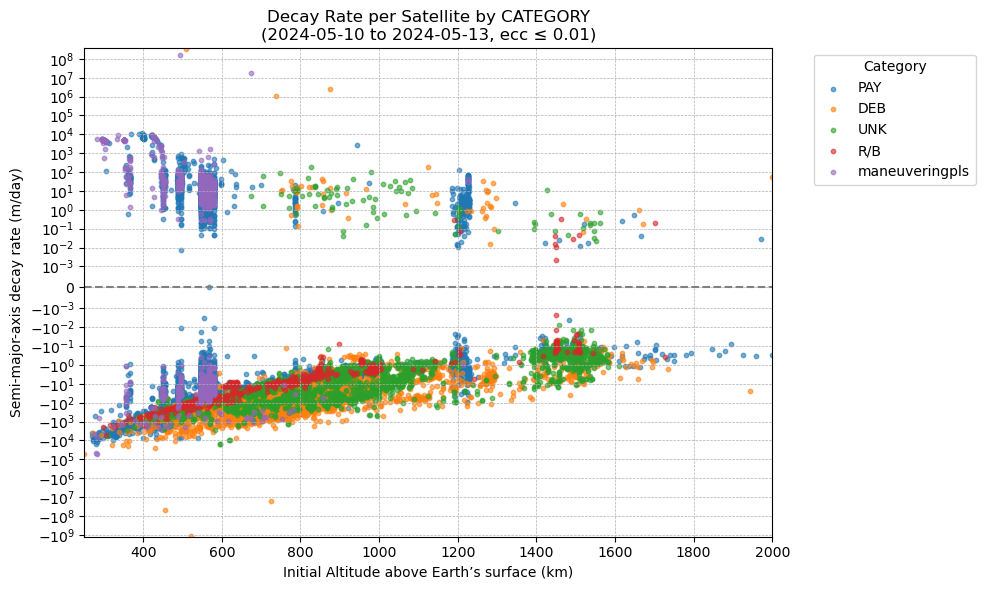

In [6]:
from datetime import timedelta
import matplotlib.pyplot as plt
# detect manoeuvring sats: altitude increase >50 m within any 3 h window
maneuvering = set()
for sat, recs in all_tle_dict.items():
    recs_p = [r for r in recs
              if start_date <= r[0].date() <= end_date
              and r[4] <= 0.01]
    if len(recs_p) < 2:
        continue
    recs_sorted = sorted(recs_p, key=lambda x: x[0])
    for i in range(len(recs_sorted)):
        for j in range(i+1, len(recs_sorted)):
            dt = recs_sorted[j][0] - recs_sorted[i][0]
            if dt > timedelta(hours=3):
                break
            da_m = (recs_sorted[j][3] - recs_sorted[i][3]) * 1000  # km→m
            if da_m > 25:
                maneuvering.add(sat)
                break
        if sat in maneuvering:
            break

# plot with new 'maneuveringpls' category
plt.figure(figsize=(10, 6))
categories = ("PAY", "DEB", "UNK", "R/B", "maneuveringpls")
for cat in categories:
    xs, ys = [], []
    for sat, (decay, alt) in decay_rates.items():
        typ = "maneuveringpls" if sat in maneuvering else types.get(sat, "UNK")
        if typ not in categories:
            typ = "UNK"
        if typ == cat:
            xs.append(alt)
            ys.append(decay * 1000)
    plt.scatter(xs, ys, s=10, alpha=0.6, label=cat)

plt.xlim(250, 2000)
ax = plt.gca()
ax.set_yscale("symlog", linthresh=1e-3)
plt.axhline(0, linestyle='--', color='grey')
plt.xlabel("Initial Altitude above Earth’s surface (km)")
plt.ylabel("Semi-major-axis decay rate (m/day)")
plt.title("Decay Rate per Satellite by CATEGORY\n(2024-05-10 to 2024-05-13, ecc ≤ 0.01)")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
#add grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
#make plot for from 10^-2 to 10^5
plt.tight_layout()
plt.show()

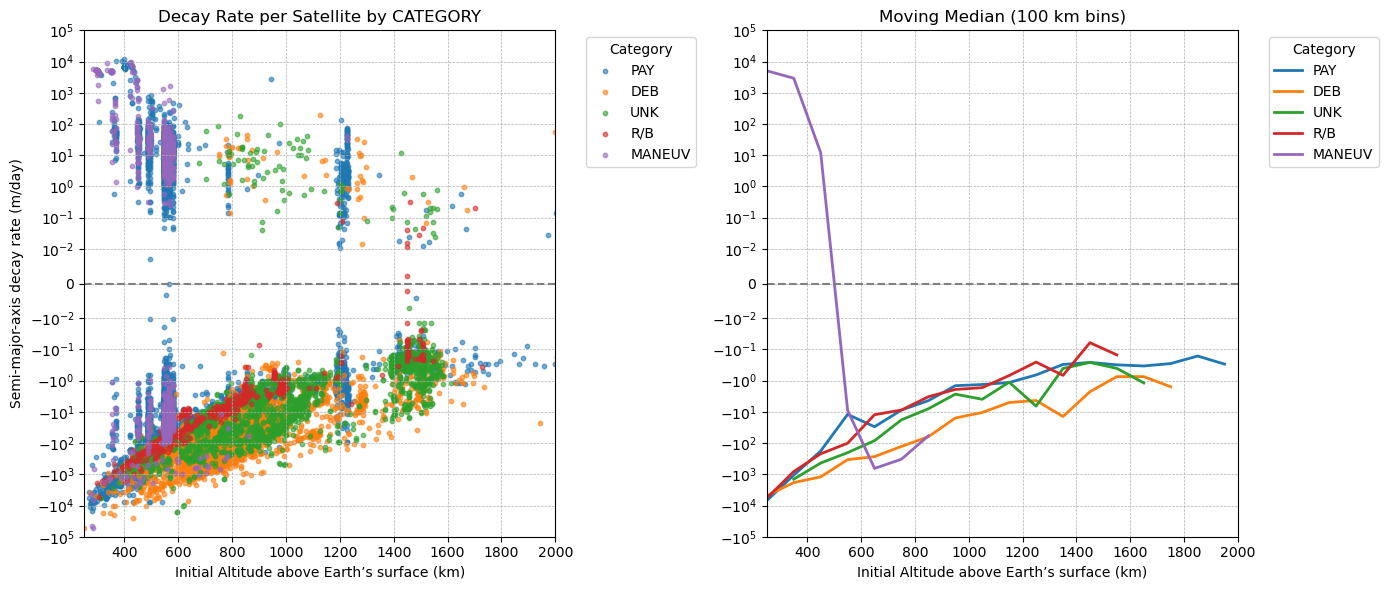

In [8]:
# … (everything up through data preparation unchanged) …

# plotting with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# left: scatter per category
for cat in categories:
    xs = np.array(data[cat]['xs'])
    ys = np.array(data[cat]['ys'])
    ax1.scatter(xs, ys, s=10, alpha=0.6, label=cat)
ax1.set_xlim(250, 2000)
ax1.set_yscale("symlog", linthresh=1e-2)
ax1.set_ylim(-1e5, 1e5)
ax1.axhline(0, linestyle='--', color='grey')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ax1.set_xlabel("Initial Altitude above Earth’s surface (km)")
ax1.set_ylabel("Semi-major-axis decay rate (m/day)")
ax1.set_title("Decay Rate per Satellite by CATEGORY")
ax1.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")

# right: moving-median lines per category
bin_edges   = np.arange(0, 2001, 100)
bin_centers = bin_edges[:-1] + 50
for cat in categories:
    xs = np.array(data[cat]['xs'])
    ys = np.array(data[cat]['ys'])
    inds = np.digitize(xs, bin_edges) - 1
    medians = [np.median(ys[inds == i]) if np.any(inds == i) else np.nan
               for i in range(len(bin_centers))]
    ax2.plot(bin_centers, medians, lw=2, label=cat)
ax2.set_xlim(250, 2000)
ax2.set_yscale("symlog", linthresh=1e-2)
ax2.set_ylim(-1e5, 1e5)
ax2.axhline(0, linestyle='--', color='grey')
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
ax2.set_xlabel("Initial Altitude above Earth’s surface (km)")
ax2.set_title("Moving Median (100 km bins)")
ax2.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

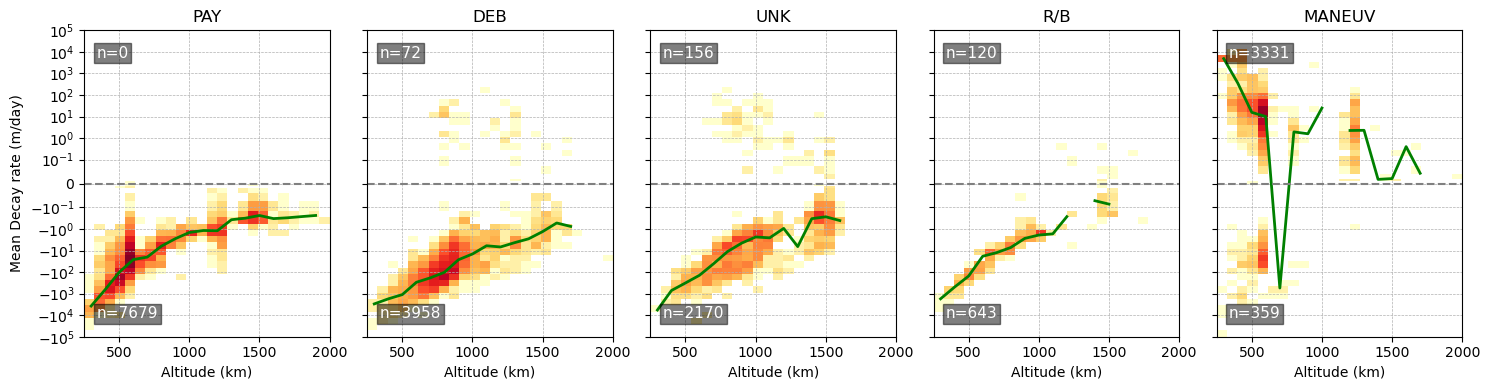

In [38]:
#!/usr/bin/env python3
from datetime import datetime, timedelta, timezone
from collections import defaultdict
import math, csv, pathlib

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

mu = 398600.4418
M, A, Cd = 1.0, 1.0, 2.2

path = pathlib.Path(
    "/Users/charlesc/Documents/GitHub/POD-Density-Inversion/"
    "source/tools/tle_archive/tle_data_2024-05-08_to_2024-05-15.tle"
)
satcat_path = pathlib.Path(
    "/Users/charlesc/Documents/GitHub/POD-Density-Inversion/"
    "source/tools/tle_archive/celestrak_satcat.csv"
)

def mm(line2):      return float(line2[52:63])
def mm_dot(line1):  return float(line1[33:43])
def epoch(line1):
    e = line1[18:32]
    return (datetime(2000 + int(e[:2]), 1, 1)
            + timedelta(days=float(e[2:]) - 1)
           ).replace(tzinfo=timezone.utc)

# 1. read TLEs
all_tle_dict = defaultdict(list)
with open(path) as f:
    lines = [ln.rstrip() for ln in f if ln.strip()]
for i in range(0, len(lines), 2):
    l1, l2 = lines[i], lines[i+1]
    sat = l1[2:7]
    t = epoch(l1)
    N = mm(l2); Ndot = mm_dot(l1)
    n = N * 2 * math.pi / 86400
    a = (mu / n**2)**(1/3)
    ecc = float("0." + l2[26:33])
    all_tle_dict[sat].append((t, a, ecc))

# 2. compute decay rates
start_date = datetime(2024, 5, 10, tzinfo=timezone.utc).date()
end_date   = datetime(2024, 5, 13, tzinfo=timezone.utc).date()
decay_rates = {}
for sat, recs in all_tle_dict.items():
    recs_p = [r for r in recs
              if start_date <= r[0].date() <= end_date and r[2] <= 0.01]
    if len(recs_p) < 2: continue
    recs_sorted = sorted(recs_p, key=lambda x: x[0])
    t0, a0 = recs_sorted[0][0], recs_sorted[0][1]
    t1, a1 = recs_sorted[-1][0], recs_sorted[-1][1]
    days = (t1 - t0).total_seconds() / 86400
    if days <= 0: continue
    decay_rates[sat] = ((a1 - a0) / days * 1000, a0 - 6371.0)

# 3. load object types
types = {}
with satcat_path.open() as f:
    for row in csv.DictReader(f):
        types[row["NORAD_CAT_ID"].lstrip("0")] = row["OBJECT_TYPE"]

# 4. detect manoeuvres
maneuvering = set()
for sat, recs in all_tle_dict.items():
    recs_p = [r for r in recs
              if start_date <= r[0].date() <= end_date and r[2] <= 0.01]
    if len(recs_p) < 2: continue
    recs_sorted = sorted(recs_p, key=lambda x: x[0])
    for i in range(len(recs_sorted)):
        for j in range(i+1, len(recs_sorted)):
            dt = recs_sorted[j][0] - recs_sorted[i][0]
            if dt > timedelta(hours=3): break
            da_m = (recs_sorted[j][1] - recs_sorted[i][1]) * 1000
            if da_m > 50:
                maneuvering.add(sat)
                break
        if sat in maneuvering: break

# 5. prepare data per category
categories = ("PAY", "DEB", "UNK", "R/B", "MANEUV")
data = {cat: {'xs': [], 'ys': []} for cat in categories}

for sat, (decay, alt) in decay_rates.items():
    orig = types.get(sat, "UNK")
    if sat in maneuvering or (orig == "PAY" and decay > 0):
        cat = "MANEUV"
    else:
        cat = orig if orig in categories else "UNK"
    data[cat]['xs'].append(alt)
    data[cat]['ys'].append(decay)

# 6. bin definitions
x_bins      = np.linspace(250, 2000, 25)
y_pos       = np.logspace(np.log10(1e-2), np.log10(1e5), 25)
y_bins      = np.concatenate([-y_pos[::-1], [0], y_pos])
bin_edges   = np.arange(250, 2001, 100)
bin_centers = bin_edges[:-1] + 50

# compute global max for color scale
counts_list = []
for cat in categories:
    xs = np.array(data[cat]['xs']); ys = np.array(data[cat]['ys'])
    if xs.size:
        H, _, _ = np.histogram2d(xs, ys, bins=[x_bins, y_bins])
        counts_list.append(H)
global_max = max(H.max() for H in counts_list) if counts_list else 1

# 7. plot
fig, axes = plt.subplots(1, len(categories), figsize=(3*len(categories), 4), sharey=True)
norm = LogNorm(vmin=1, vmax=global_max)
cmap = plt.cm.YlOrRd
cmap.set_under('lightgrey')

for ax, cat in zip(axes, categories):
    xs = np.array(data[cat]['xs']); ys = np.array(data[cat]['ys'])
    if xs.size:
        ax.hist2d(xs, ys, bins=[x_bins, y_bins], norm=norm, cmap=cmap)
    # moving median
    inds = np.digitize(xs, bin_edges) - 1
    medians = [np.median(ys[inds == i]) if np.any(inds == i) else np.nan
               for i in range(len(bin_centers))]
    ax.plot(bin_centers, medians, color='green', linewidth=2)

    # annotate counts above and below zero
    n_pos = np.sum(ys > 0)
    n_neg = np.sum(ys < 0)
    ax.text(0.05, 0.95, f"n={n_pos}", transform=ax.transAxes,
            va='top', ha='left', color='white', fontsize=11,
            bbox=dict(facecolor='black', alpha=0.5, pad=2))
    ax.text(0.05, 0.05, f"n={n_neg}", transform=ax.transAxes,
            va='bottom', ha='left', color='white', fontsize=11,
            bbox=dict(facecolor='black', alpha=0.5, pad=2))

    ax.set_title(cat)
    ax.set_xlim(250, 2000)
    ax.set_xscale('linear')
    ax.set_yscale('symlog', linthresh=1e-1)
    ax.set_ylim(-1e5, 1e5)
    ax.axhline(0, linestyle='--', color='grey')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.set_xlabel("Altitude (km)")

axes[0].set_ylabel("Mean Decay rate (m/day)")
# cb = fig.colorbar(axes[-1].collections[0], ax=axes, location='right', fraction=0.02)
# cb.set_label('Count')

plt.tight_layout()
plt.savefig("storm_decay_obj.png", dpi=300)
plt.show()

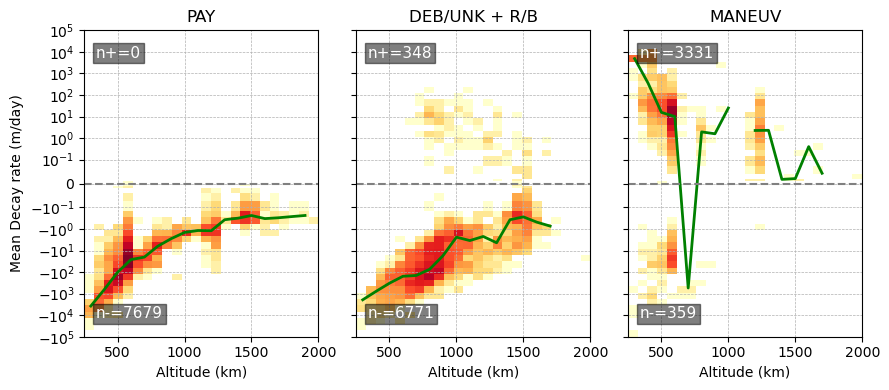

In [ ]:
# 5. prepare data per combined category
categories = ("PAY", "DEB/UNK + R/B", "MANEUV")
data = {cat: {'xs': [], 'ys': []} for cat in categories}

for sat, (decay, alt) in decay_rates.items():
    orig = types.get(sat, "UNK")
    if sat in maneuvering or (orig == "PAY" and decay > 0):
        cat = "MANEUV"
    elif orig == "PAY":
        cat = "PAY"
    elif orig in ("DEB", "UNK", "R/B"):
        cat = "DEB + UNK + R/B"
    else:
        continue
    data[cat]['xs'].append(alt)
    data[cat]['ys'].append(decay)

# 7. plot with updated categories
fig, axes = plt.subplots(1, len(categories), figsize=(3*len(categories), 4), sharey=True)
norm = LogNorm(vmin=1, vmax=global_max)
cmap = plt.cm.YlOrRd
cmap.set_under('lightgrey')

for ax, cat in zip(axes, categories):
    xs = np.array(data[cat]['xs']); ys = np.array(data[cat]['ys'])
    if xs.size:
        ax.hist2d(xs, ys, bins=[x_bins, y_bins], norm=norm, cmap=cmap)
    inds = np.digitize(xs, bin_edges) - 1
    medians = [np.median(ys[inds == i]) if np.any(inds == i) else np.nan
               for i in range(len(bin_centers))]
    ax.plot(bin_centers, medians, color='green', linewidth=2)
    n_pos = np.sum(ys > 0); n_neg = np.sum(ys < 0)
    ax.text(0.05, 0.95, f"n+={n_pos}", transform=ax.transAxes,
            va='top', ha='left', color='white', fontsize=11,
            bbox=dict(facecolor='black', alpha=0.5, pad=2))
    ax.text(0.05, 0.05, f"n-={n_neg}", transform=ax.transAxes,
            va='bottom', ha='left', color='white', fontsize=11,
            bbox=dict(facecolor='black', alpha=0.5, pad=2))
    ax.set_title(cat)
    ax.set_xlim(250, 2000)
    ax.set_xscale('linear')
    ax.set_yscale('symlog', linthresh=1e-1)
    ax.set_ylim(-1e5, 1e5)
    ax.axhline(0, linestyle='--', color='grey')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.set_xlabel("Altitude (km)")

axes[0].set_ylabel("Mean Decay rate (m/day)")
plt.tight_layout()
plt.savefig("storm_decay_obj_combined.png", dpi=300)
plt.show()

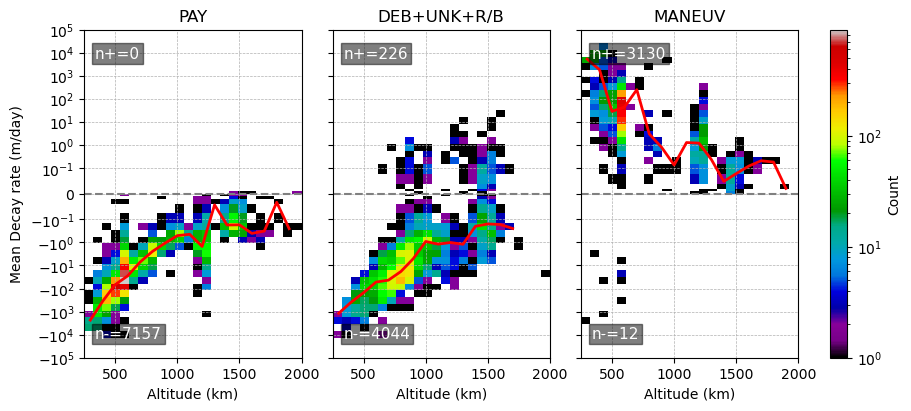

In [85]:
#!/usr/bin/env python3
from datetime import datetime, timedelta, timezone
from collections import defaultdict
import math, csv, pathlib

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

mu = 398600.4418

path = pathlib.Path(
    "/Users/charlesc/Documents/GitHub/POD-Density-Inversion/"
    "source/tools/tle_archive/tle_data_2024-05-08_to_2024-05-15.tle"
)
satcat_path = pathlib.Path(
    "/Users/charlesc/Documents/GitHub/POD-Density-Inversion/"
    "source/tools/tle_archive/celestrak_satcat.csv"
)

def mm(line2):      return float(line2[52:63])
def epoch(line1):
    e = line1[18:32]
    return (datetime(2000 + int(e[:2]), 1, 1)
            + timedelta(days=float(e[2:]) - 1)
           ).replace(tzinfo=timezone.utc)

# 1) read all TLEs
all_tle = defaultdict(list)
with open(path) as f:
    lines = [l.rstrip() for l in f if l.strip()]
for i in range(0, len(lines), 2):
    l1, l2 = lines[i], lines[i+1]
    sat = l1[2:7]
    t   = epoch(l1)
    N   = mm(l2)
    n   = N * 2 * math.pi / 86400
    a   = (mu / n**2)**(1/3)
    ecc = float("0." + l2[26:33])
    all_tle[sat].append((t, a, ecc))

# 2) helper to compute decay & altitude in a window
def decay_in_window(start_date, end_date):
    rates, alts = {}, {}
    for sat, recs in all_tle.items():
        recs_p = [r for r in recs
                  if start_date <= r[0].date() <= end_date and r[2] <= 0.01]
        if len(recs_p) < 2:
            continue
        recs_p.sort(key=lambda x: x[0])
        t0, a0 = recs_p[0][0], recs_p[0][1]
        t1, a1 = recs_p[-1][0], recs_p[-1][1]
        days = (t1 - t0).total_seconds() / 86400
        if days <= 0:
            continue
        rates[sat] = (a1 - a0) / days * 1000
        alts[sat]  = a0 - 6371.0
    return rates, alts

# 3) define windows
pre_start, pre_end     = datetime(2024,5,7,tzinfo=timezone.utc).date(),  datetime(2024,5,8,tzinfo=timezone.utc).date()
storm_start, storm_end = datetime(2024,5,10,tzinfo=timezone.utc).date(), datetime(2024,5,13,tzinfo=timezone.utc).date()

pre_rates, alts_pre     = decay_in_window(pre_start,  pre_end)
storm_rates, alts_storm = decay_in_window(storm_start, storm_end)

# 4) keep only sats present in both windows
common_sats = set(pre_rates) & set(storm_rates)

# 5) load object types
types = {}
with satcat_path.open() as f:
    for row in csv.DictReader(f):
        types[row["NORAD_CAT_ID"].lstrip("0")] = row["OBJECT_TYPE"]

# 6) detect manoeuvres in pre-storm window
maneuvering = set()
for sat in common_sats:
    recs_p = [r for r in all_tle[sat]
              if pre_start <= r[0].date() <= pre_end and r[2] <= 0.01]
    recs_p.sort(key=lambda x: x[0])
    for i in range(len(recs_p)):
        for j in range(i+1, len(recs_p)):
            if recs_p[j][0] - recs_p[i][0] > timedelta(hours=3):
                break
            if (recs_p[j][1] - recs_p[i][1]) * 1000 > 50:
                maneuvering.add(sat)
                break
        if sat in maneuvering:
            break

# 7) prepare categorized data for pre-storm only (filtered)
categories = ("PAY", "DEB+UNK+R/B", "MANEUV")
data = {cat: {'xs': [], 'ys': []} for cat in categories}

for sat in common_sats:
    decay, alt = pre_rates[sat], alts_pre[sat]
    orig = types.get(sat, "UNK")
    if sat in maneuvering or (orig == "PAY" and decay > 0):
        cat = "MANEUV"
    elif orig == "PAY":
        cat = "PAY"
    else:
        cat = "DEB+UNK+R/B"
    data[cat]['xs'].append(alt)
    data[cat]['ys'].append(decay)

# 8) bin definitions
x_bins      = np.linspace(250, 2000, 25)
y_pos       = np.logspace(np.log10(1e-2), np.log10(1e5), 25)
y_bins      = np.concatenate([-y_pos[::-1], [0], y_pos])
bin_edges   = np.arange(250, 2001, 100)
bin_centers = bin_edges[:-1] + 50

# compute global max for color scale
counts_list = []
for cat in categories:
    xs = np.array(data[cat]['xs']); ys = np.array(data[cat]['ys'])
    if xs.size:
        H, _, _ = np.histogram2d(xs, ys, bins=[x_bins, y_bins])
        counts_list.append(H)
global_max = max(H.max() for H in counts_list) if counts_list else 1

# 9) plot pre-storm decay rates (filtered)
fig, axes = plt.subplots(
    1, len(categories), figsize=(3*len(categories), 4),
    sharey=True, constrained_layout=True
)
norm = LogNorm(vmin=1, vmax=global_max)
cmap = plt.cm.nipy_spectral
cmap.set_under('lightgrey')

for ax, cat in zip(axes, categories):
    xs = np.array(data[cat]['xs']); ys = np.array(data[cat]['ys'])
    if xs.size:
        ax.hist2d(xs, ys, bins=[x_bins, y_bins], norm=norm, cmap=cmap)
    inds = np.digitize(xs, bin_edges) - 1
    medians = [
        np.median(ys[inds == i]) if np.any(inds == i) else np.nan
        for i in range(len(bin_centers))
    ]
    ax.plot(bin_centers, medians, color='red', linewidth=2)
    n_pos = np.sum(ys > 0); n_neg = np.sum(ys < 0)
    ax.text(0.05, 0.95, f"n+={n_pos}", transform=ax.transAxes,
            va='top', ha='left', color='white', fontsize=11,
            bbox=dict(facecolor='black', alpha=0.5, pad=2))
    ax.text(0.05, 0.05, f"n-={n_neg}", transform=ax.transAxes,
            va='bottom', ha='left', color='white', fontsize=11,
            bbox=dict(facecolor='black', alpha=0.5, pad=2))
    ax.set_title(cat)
    ax.set_xlim(250, 2000)
    ax.set_xscale('linear')
    ax.set_yscale('symlog', linthresh=1e-1)
    ax.set_ylim(-1e5, 1e5)
    ax.axhline(0, linestyle='--', color='grey')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.set_xlabel("Altitude (km)")

axes[0].set_ylabel("Mean Decay rate (m/day)")

cbar = fig.colorbar(axes[-1].collections[0], ax=axes,
                    location='right', fraction=0.025, pad=0.02)
cbar.set_label('Count')

plt.savefig("prestorm_decay_filtered.png", dpi=300)
plt.show()

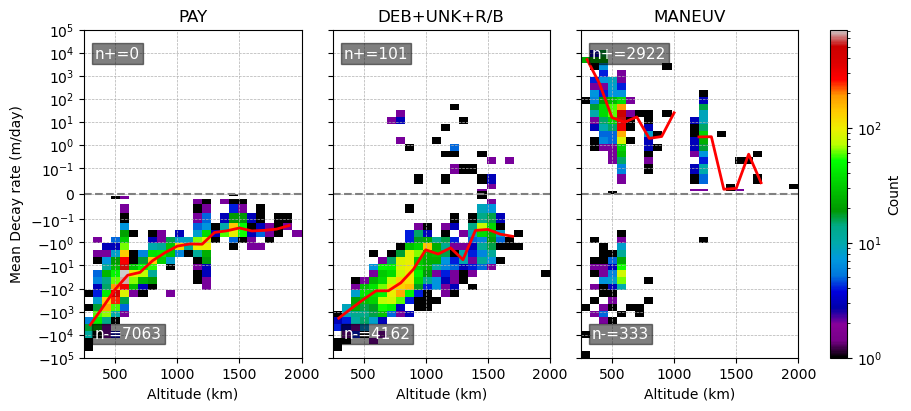

In [84]:
#!/usr/bin/env python3
from datetime import datetime, timedelta, timezone
from collections import defaultdict
import math, csv, pathlib

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

mu = 398600.4418

path = pathlib.Path(
    "/Users/charlesc/Documents/GitHub/POD-Density-Inversion/"
    "source/tools/tle_archive/tle_data_2024-05-08_to_2024-05-15.tle"
)
satcat_path = pathlib.Path(
    "/Users/charlesc/Documents/GitHub/POD-Density-Inversion/"
    "source/tools/tle_archive/celestrak_satcat.csv"
)

def mm(line2):      return float(line2[52:63])
def mm_dot(line1):  return float(line1[33:43])
def epoch(line1):
    e = line1[18:32]
    return (datetime(2000 + int(e[:2]), 1, 1)
            + timedelta(days=float(e[2:]) - 1)
           ).replace(tzinfo=timezone.utc)

# 1) read all TLEs
all_tle_dict = defaultdict(list)
with open(path) as f:
    lines = [ln.rstrip() for ln in f if ln.strip()]
for i in range(0, len(lines), 2):
    l1, l2 = lines[i], lines[i+1]
    sat = l1[2:7]
    t   = epoch(l1)
    N   = mm(l2)
    n   = N * 2 * math.pi / 86400
    a   = (mu / n**2)**(1/3)
    ecc = float("0." + l2[26:33])
    all_tle_dict[sat].append((t, a, ecc))

# 2) helper to compute decay & altitude in a window
def decay_in_window(start_date, end_date):
    rates, alts = {}, {}
    for sat, recs in all_tle_dict.items():
        recs_p = [r for r in recs
                  if start_date <= r[0].date() <= end_date and r[2] <= 0.01]
        if len(recs_p) < 2:
            continue
        recs_p.sort(key=lambda x: x[0])
        t0, a0 = recs_p[0][0], recs_p[0][1]
        t1, a1 = recs_p[-1][0], recs_p[-1][1]
        days = (t1 - t0).total_seconds() / 86400
        if days <= 0:
            continue
        rates[sat] = (a1 - a0) / days * 1000
        alts[sat]  = a0 - 6371.0
    return rates, alts

# 3) define windows
pre_start, pre_end     = datetime(2024,5,7,tzinfo=timezone.utc).date(), datetime(2024,5,8,tzinfo=timezone.utc).date()
storm_start, storm_end = datetime(2024,5,10,tzinfo=timezone.utc).date(), datetime(2024,5,13,tzinfo=timezone.utc).date()

pre_rates, alts_pre     = decay_in_window(pre_start,  pre_end)
storm_rates, alts_storm = decay_in_window(storm_start, storm_end)

# 4) keep only sats present in both windows
common_sats = set(pre_rates) & set(storm_rates)

# 5) load object types
types = {}
with satcat_path.open() as f:
    for row in csv.DictReader(f):
        types[row["NORAD_CAT_ID"].lstrip("0")] = row["OBJECT_TYPE"]

# 6) detect manoeuvres in storm window
maneuvering = set()
for sat in common_sats:
    recs_p = [r for r in all_tle_dict[sat]
              if storm_start <= r[0].date() <= storm_end and r[2] <= 0.01]
    if len(recs_p) < 2:
        continue
    recs_p.sort(key=lambda x: x[0])
    for i in range(len(recs_p)):
        for j in range(i+1, len(recs_p)):
            dt = recs_p[j][0] - recs_p[i][0]
            if dt > timedelta(hours=3):
                break
            if (recs_p[j][1] - recs_p[i][1]) * 1000 > 50:
                maneuvering.add(sat)
                break
        if sat in maneuvering:
            break

# 7) categorize & collect storm-period data for common_sats
categories = ("PAY", "DEB+UNK+R/B", "MANEUV")
data = {cat: {'xs': [], 'ys': []} for cat in categories}

for sat in common_sats:
    decay, alt = storm_rates[sat], alts_storm[sat]
    orig = types.get(sat, "UNK")
    if sat in maneuvering or (orig == "PAY" and decay > 0):
        cat = "MANEUV"
    elif orig == "PAY":
        cat = "PAY"
    else:
        cat = "DEB+UNK+R/B"
    data[cat]['xs'].append(alt)
    data[cat]['ys'].append(decay)

# 8) bin definitions
x_bins      = np.linspace(250, 2000, 25)
y_pos       = np.logspace(np.log10(1e-2), np.log10(1e5), 25)
y_bins      = np.concatenate([-y_pos[::-1], [0], y_pos])
bin_edges   = np.arange(250, 2001, 100)
bin_centers = bin_edges[:-1] + 50

# compute global max for color scale
counts_list = []
for cat in categories:
    xs = np.array(data[cat]['xs']); ys = np.array(data[cat]['ys'])
    if xs.size:
        H, _, _ = np.histogram2d(xs, ys, bins=[x_bins, y_bins])
        counts_list.append(H)
global_max = max(H.max() for H in counts_list) if counts_list else 1

# 9) plot storm-period decay rates (filtered)
fig, axes = plt.subplots(
    1, len(categories), figsize=(3*len(categories), 4),
    sharey=True, constrained_layout=True
)
norm = LogNorm(vmin=1, vmax=global_max)
cmap = plt.cm.nipy_spectral
cmap.set_under('lightgrey')

for ax, cat in zip(axes, categories):
    xs = np.array(data[cat]['xs']); ys = np.array(data[cat]['ys'])
    if xs.size:
        ax.hist2d(xs, ys, bins=[x_bins, y_bins], norm=norm, cmap=cmap)
    inds = np.digitize(xs, bin_edges) - 1
    medians = [
        np.median(ys[inds == i]) if np.any(inds == i) else np.nan
        for i in range(len(bin_centers))
    ]
    ax.plot(bin_centers, medians, color='red', linewidth=2)
    n_pos = np.sum(ys > 0); n_neg = np.sum(ys < 0)
    ax.text(0.05, 0.95, f"n+={n_pos}", transform=ax.transAxes,
            va='top', ha='left', color='white', fontsize=11,
            bbox=dict(facecolor='black', alpha=0.5, pad=2))
    ax.text(0.05, 0.05, f"n-={n_neg}", transform=ax.transAxes,
            va='bottom', ha='left', color='white', fontsize=11,
            bbox=dict(facecolor='black', alpha=0.5, pad=2))
    ax.set_title(cat)
    ax.set_xlim(250, 2000)
    ax.set_xscale('linear')
    ax.set_yscale('symlog', linthresh=1e-1)
    ax.set_ylim(-1e5, 1e5)
    ax.axhline(0, linestyle='--', color='grey')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.set_xlabel("Altitude (km)")

axes[0].set_ylabel("Mean Decay rate (m/day)")

cbar = fig.colorbar(axes[-1].collections[0], ax=axes,
                    location='right', fraction=0.025, pad=0.02)
cbar.set_label('Count')

plt.savefig("storm_decay_filtered.png", dpi=300)
plt.show()

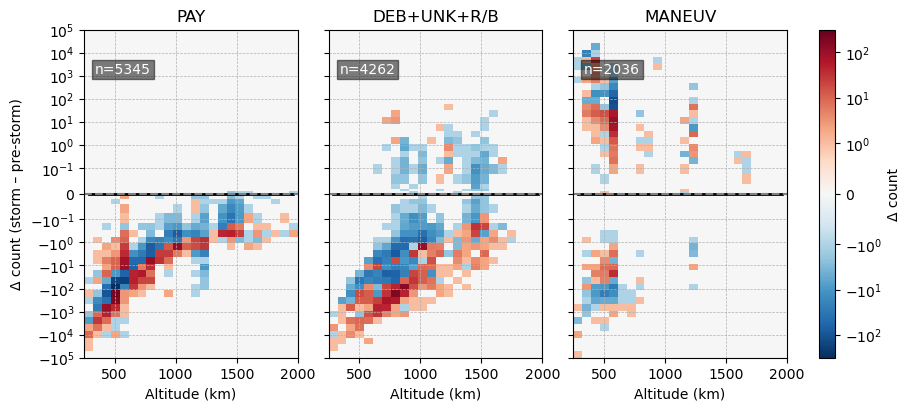

In [82]:
#!/usr/bin/env python3
from datetime import datetime, timedelta, timezone
from collections import defaultdict
import math, csv, pathlib

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm, LogNorm

mu = 398600.4418

path = pathlib.Path(
    "/Users/charlesc/Documents/GitHub/POD-Density-Inversion/"
    "source/tools/tle_archive/tle_data_2024-05-08_to_2024-05-15.tle"
)
satcat_path = pathlib.Path(
    "/Users/charlesc/Documents/GitHub/POD-Density-Inversion/"
    "source/tools/tle_archive/celestrak_satcat.csv"
)

def mm(line2): return float(line2[52:63])
def epoch(line1):
    e = line1[18:32]
    return (datetime(2000+int(e[:2]),1,1) + timedelta(days=float(e[2:])-1)
           ).replace(tzinfo=timezone.utc)

# 1) read all TLEs
all_tle = defaultdict(list)
with open(path) as f:
    lines = [l.rstrip() for l in f if l.strip()]
for i in range(0, len(lines), 2):
    l1, l2 = lines[i], lines[i+1]
    sat = l1[2:7]
    t   = epoch(l1)
    N   = mm(l2)
    n   = N*2*math.pi/86400
    a   = (mu/n**2)**(1/3)
    ecc = float("0."+l2[26:33])
    all_tle[sat].append((t,a,ecc))

# 2) load object types
types = {}
with satcat_path.open() as f:
    for row in csv.DictReader(f):
        types[row["NORAD_CAT_ID"].lstrip("0")] = row["OBJECT_TYPE"]

# 3) detect maneuvering (>50 m in 3 h)
maneuvering = set()
for sat, recs in all_tle.items():
    recs_p = sorted([r for r in recs if r[2]<=0.01], key=lambda x:x[0])
    for i in range(len(recs_p)):
        for j in range(i+1, len(recs_p)):
            if recs_p[j][0]-recs_p[i][0] > timedelta(hours=3):
                break
            if (recs_p[j][1]-recs_p[i][1])*1000 > 50:
                maneuvering.add(sat)
                break
        if sat in maneuvering:
            break

# 4) compute decay & altitude in a window
def decay_in_window(start, end):
    rates, alts = {}, {}
    for sat, recs in all_tle.items():
        recs_p = sorted(
            [r for r in recs if start<=r[0].date()<=end and r[2]<=0.01],
            key=lambda x:x[0]
        )
        if len(recs_p)<2: 
            continue
        t0,a0 = recs_p[0][0], recs_p[0][1]
        t1,a1 = recs_p[-1][0], recs_p[-1][1]
        days = (t1-t0).total_seconds()/86400
        if days<=0:
            continue
        rates[sat] = (a1-a0)/days*1000
        alts[sat]  = a0-6371.0
    return rates, alts

# 5) define windows
pre_start, pre_end     = datetime(2024,5,7,tzinfo=timezone.utc).date(), datetime(2024,5,8,tzinfo=timezone.utc).date()
storm_start, storm_end = datetime(2024,5,10,tzinfo=timezone.utc).date(), datetime(2024,5,13,tzinfo=timezone.utc).date()

pre_rates, alts_pre     = decay_in_window(pre_start, pre_end)
storm_rates, alts_storm = decay_in_window(storm_start, storm_end)

# 6) keep only sats present in both
common_sats = set(pre_rates) & set(storm_rates)

# 7) classification helper
def classify(sat, rate):
    orig = types.get(sat, "UNK")
    if sat in maneuvering or (orig=="PAY" and rate>0):
        return "MANEUV"
    if orig=="PAY":
        return "PAY"
    return "DEB+UNK+R/B"

# 8) bins
x_bins = np.linspace(250,2000,25)
y_pos  = np.logspace(np.log10(1e-2), np.log10(1e5), 25)
y_bins = np.concatenate([-y_pos[::-1],[0],y_pos])
categories = ("PAY","DEB+UNK+R/B","MANEUV")

# 9) build histograms only for sats that remain in same category both windows
H_pre, H_str = {}, {}
counts = {}

for cat in categories:
    # sats in this cat both pre and storm
    sats_pre  = {sat for sat in common_sats if classify(sat, pre_rates[sat])==cat}
    sats_str  = {sat for sat in common_sats if classify(sat, storm_rates[sat])==cat}
    sats_both = sats_pre & sats_str
    
    xs_pre = [alts_pre[s] for s in sats_both]
    ys_pre = [pre_rates[s] for s in sats_both]
    xs_str = [alts_storm[s] for s in sats_both]
    ys_str = [storm_rates[s] for s in sats_both]
    
    H_pre[cat],   _, _ = np.histogram2d(xs_pre, ys_pre, bins=[x_bins,y_bins])
    H_str[cat],   _, _ = np.histogram2d(xs_str, ys_str, bins=[x_bins,y_bins])
    counts[cat]       = len(sats_both)

# 10) compute norm
max_diff = max(np.max(np.abs(H_str[c]-H_pre[c])) for c in categories)
norm = SymLogNorm(linthresh=1, linscale=1, vmin=-max_diff, vmax=max_diff)
cmap = plt.cm.RdBu_r

# 11) plot diff
fig, axes = plt.subplots(1, len(categories), figsize=(3*len(categories),4),
                         sharey=True, constrained_layout=True)
for ax, cat in zip(axes, categories):
    diff = H_str[cat] - H_pre[cat]
    X, Y = np.meshgrid(x_bins, y_bins)
    pcm = ax.pcolormesh(X, Y, diff.T, norm=norm, cmap=cmap)
    centers = x_bins[:-1] + np.diff(x_bins)/2
    med     = [np.median(diff[i,:]) for i in range(len(centers))]
    ax.plot(centers, med, color='black', linewidth=2)
    ax.axhline(0, linestyle='--', color='grey')
    ax.text(0.05,0.90, f"n={counts[cat]}", transform=ax.transAxes,
            va='top', ha='left', color='white',
            bbox=dict(facecolor='black', alpha=0.5, pad=2))
    ax.set_xscale('linear')
    ax.set_yscale('symlog', linthresh=1e-1)
    ax.set_xlim(250,2000)
    ax.set_ylim(-1e5,1e5)
    ax.set_title(cat)
    ax.set_xlabel("Altitude (km)")

axes[0].set_ylabel("Δ count (storm – pre‐storm)")

cbar = fig.colorbar(pcm, ax=axes, location='right', fraction=0.025, pad=0.02)
cbar.set_label("Δ count")

for ax in axes:
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

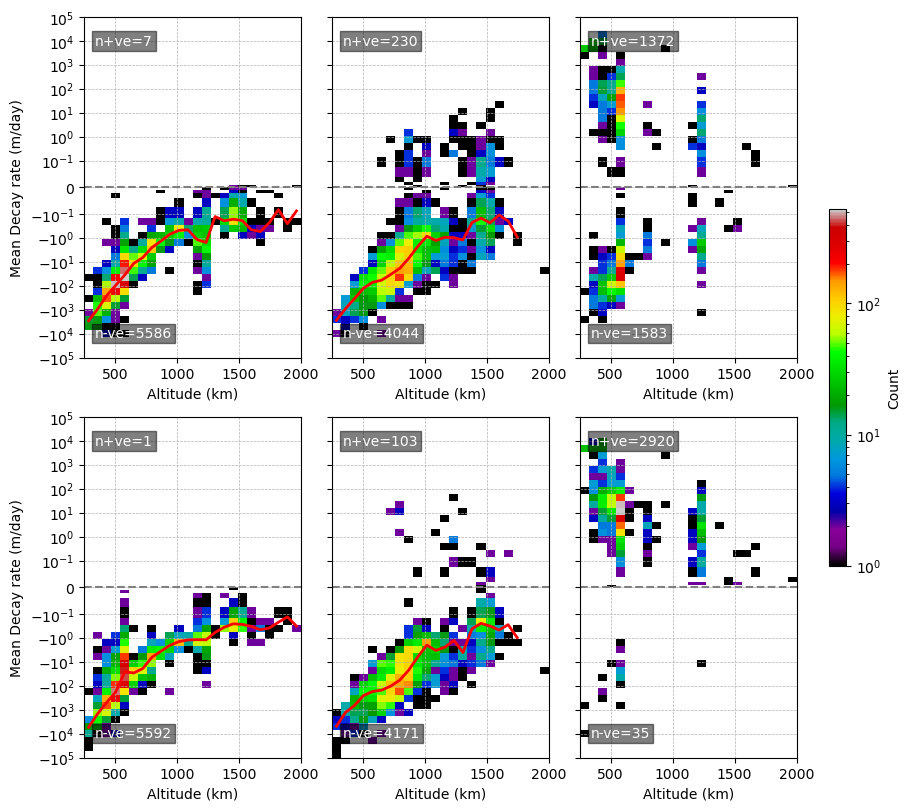

In [100]:
#!/usr/bin/env python3
from datetime import datetime, timedelta, timezone
from collections import defaultdict
import math, csv, pathlib

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

mu = 398600.4418

path = pathlib.Path(
    "/Users/charlesc/Documents/GitHub/POD-Density-Inversion/"
    "source/tools/tle_archive/tle_data_2024-05-08_to_2024-05-15.tle"
)
satcat_path = pathlib.Path(
    "/Users/charlesc/Documents/GitHub/POD-Density-Inversion/"
    "source/tools/tle_archive/celestrak_satcat.csv"
)

def mm(line2):
    return float(line2[52:63])

def epoch(line1):
    e = line1[18:32]
    return (datetime(2000 + int(e[:2]), 1, 1)
            + timedelta(days=float(e[2:]) - 1)
           ).replace(tzinfo=timezone.utc)

# 1) read all TLEs
all_tle = defaultdict(list)
with open(path) as f:
    lines = [l.rstrip() for l in f if l.strip()]
for i in range(0, len(lines), 2):
    l1, l2 = lines[i], lines[i+1]
    sat = l1[2:7]
    t   = epoch(l1)
    N   = mm(l2)
    n   = N * 2 * math.pi / 86400
    a   = (mu / n**2)**(1/3)
    ecc = float("0." + l2[26:33])
    all_tle[sat].append((t, a, ecc))

# 2) decay‐rate helper
def decay_in_window(start, end):
    rates, alts = {}, {}
    for sat, recs in all_tle.items():
        recs_p = [r for r in recs
                  if start <= r[0].date() <= end and r[2] <= 0.01]
        if len(recs_p) < 2:
            continue
        recs_p.sort(key=lambda x: x[0])
        t0, a0 = recs_p[0][0], recs_p[0][1]
        t1, a1 = recs_p[-1][0], recs_p[-1][1]
        days = (t1 - t0).total_seconds() / 86400
        if days <= 0:
            continue
        rates[sat] = (a1 - a0) / days * 1000
        alts[sat]  = a0 - 6371.0
    return rates, alts

# 3) define windows
pre_start, pre_end     = datetime(2024,5,7,tzinfo=timezone.utc).date(), datetime(2024,5,8,tzinfo=timezone.utc).date()
storm_start, storm_end = datetime(2024,5,10,tzinfo=timezone.utc).date(), datetime(2024,5,13,tzinfo=timezone.utc).date()

pre_rates, alts_pre     = decay_in_window(pre_start,  pre_end)
storm_rates, alts_storm = decay_in_window(storm_start, storm_end)

# 4) keep only sats seen both windows
common_sats = set(pre_rates) & set(storm_rates)

# 5) load object types
types = {}
with satcat_path.open() as f:
    for row in csv.DictReader(f):
        types[row["NORAD_CAT_ID"].lstrip("0")] = row["OBJECT_TYPE"]

# 6) detect maneuvering in pre‐storm window
maneuvering = set()
for sat in common_sats:
    recs_p = [r for r in all_tle[sat]
              if pre_start <= r[0].date() <= pre_end and r[2] <= 0.01]
    recs_p.sort(key=lambda x: x[0])
    for i in range(len(recs_p)):
        for j in range(i+1, len(recs_p)):
            if recs_p[j][0] - recs_p[i][0] > timedelta(hours=3):
                break
            if (recs_p[j][1] - recs_p[i][1]) * 1000 > 50:
                maneuvering.add(sat)
                break
        if sat in maneuvering:
            break

# 7) classify into categories
categories = ("PAY", "DEB+UNK+R/B", "MANEUV")
sats_pre_cat = {cat:set() for cat in categories}
sats_str_cat = {cat:set() for cat in categories}

def classify(sat, rate):
    orig = types.get(sat, "UNK")
    if sat in maneuvering or (orig=="PAY" and rate > 0):
        return "MANEUV"
    if orig == "PAY":
        return "PAY"
    return "DEB+UNK+R/B"

for sat in common_sats:
    sats_pre_cat[classify(sat, pre_rates[sat])].add(sat)
    sats_str_cat[classify(sat, storm_rates[sat])].add(sat)

# 8) require intersection for non‐MANEUV, allow all MANEUV
sats_both_cat = {
    cat: (sats_pre_cat[cat] & sats_str_cat[cat]) if cat != "MANEUV"
         else sats_str_cat["MANEUV"]
    for cat in categories
}

# 9) gather data
data_pre = {cat:{'xs':[], 'ys':[]} for cat in categories}
data_str = {cat:{'xs':[], 'ys':[]} for cat in categories}
counts   = {}

for cat in categories:
    sats_pre = sats_both_cat[cat]
    sats_str = sats_both_cat[cat]
    counts[cat] = len(sats_str)
    for sat in sats_pre:
        data_pre[cat]['xs'].append(alts_pre[sat])
        data_pre[cat]['ys'].append(pre_rates[sat])
    for sat in sats_str:
        data_str[cat]['xs'].append(alts_storm[sat])
        data_str[cat]['ys'].append(storm_rates[sat])

# 10) bins & global max
x_bins      = np.linspace(250, 2000, 25)
y_pos       = np.logspace(np.log10(1e-2), np.log10(1e5), 25)
y_bins      = np.concatenate([-y_pos[::-1], [0], y_pos])

counts_list = []
for cat in categories:
    xs, ys = np.array(data_str[cat]['xs']), np.array(data_str[cat]['ys'])
    if xs.size:
        H, _, _ = np.histogram2d(xs, ys, bins=[x_bins, y_bins])
        counts_list.append(H)
global_max = max(H.max() for H in counts_list) if counts_list else 1

# 11) plot pre‐storm and in‐storm side by side with n+ve / n-ve
fig, axes = plt.subplots(2, len(categories), figsize=(3*len(categories), 8),
                         sharey=True, constrained_layout=True)
norm = LogNorm(vmin=1, vmax=global_max)
cmap = plt.cm.nipy_spectral; cmap.set_under('lightgrey')

for row, data in enumerate((data_pre, data_str)):
    for ax, cat in zip(axes[row], categories):
        xs = np.array(data[cat]['xs']); ys = np.array(data[cat]['ys'])
        if xs.size:
            ax.hist2d(xs, ys, bins=[x_bins, y_bins], norm=norm, cmap=cmap)
        if cat != "MANEUV":
            med = [
                np.median(ys[(np.digitize(xs, x_bins)-1) == i])
                if np.any((np.digitize(xs, x_bins)-1) == i) else np.nan
                for i in range(len(x_bins)-1)
            ]
            ax.plot(x_bins[:-1] + np.diff(x_bins)/2, med, color='red', lw=2)
        # split counts, include zeros in positive
        n_pos = np.sum(ys >= 0)
        n_neg = np.sum(ys < 0)
        ax.text(0.05, 0.95, f"n+ve={n_pos}", transform=ax.transAxes,
                va='top', ha='left', color='white',
                bbox=dict(facecolor='black', alpha=0.5, pad=2))
        ax.text(0.05, 0.05, f"n-ve={n_neg}", transform=ax.transAxes,
                va='bottom', ha='left', color='white',
                bbox=dict(facecolor='black', alpha=0.5, pad=2))
        ax.set_xlim(250, 2000)
        ax.set_xscale('linear')
        ax.set_yscale('symlog', linthresh=1e-1)
        ax.set_ylim(-1e5, 1e5)
        ax.axhline(0, linestyle='--', color='grey')
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax.set_xlabel("Altitude (km)")
    axes[row][0].set_ylabel("Mean Decay rate (m/day)")

cbar = fig.colorbar(axes[1][-1].collections[0], ax=axes,
                    location='right', fraction=0.025, pad=0.02)
cbar.set_label("Count")

plt.savefig("storm_decay_obj_combined.png", dpi=300)
plt.show()

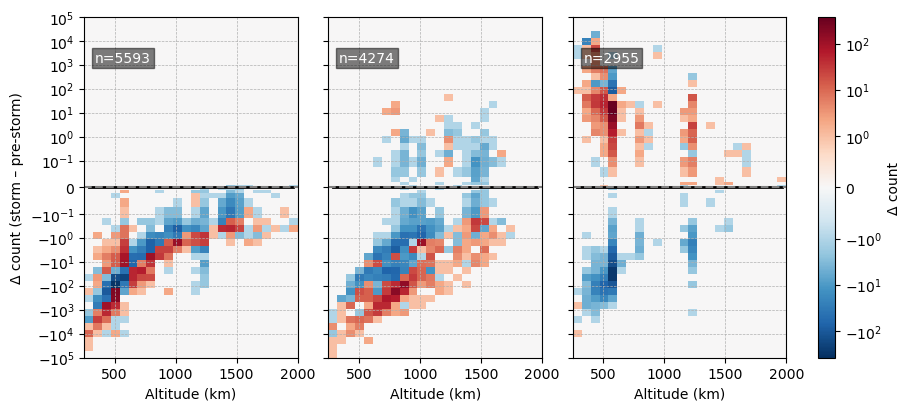

In [95]:
#!/usr/bin/env python3
from datetime import datetime, timedelta, timezone
from collections import defaultdict
import math, csv, pathlib

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm

mu = 398600.4418

path = pathlib.Path(
    "/Users/charlesc/Documents/GitHub/POD-Density-Inversion/"
    "source/tools/tle_archive/tle_data_2024-05-08_to_2024-05-15.tle"
)
satcat_path = pathlib.Path(
    "/Users/charlesc/Documents/GitHub/POD-Density-Inversion/"
    "source/tools/tle_archive/celestrak_satcat.csv"
)

def mm(line2):
    return float(line2[52:63])

def epoch(line1):
    e = line1[18:32]
    return (datetime(2000 + int(e[:2]), 1, 1)
            + timedelta(days=float(e[2:]) - 1)
           ).replace(tzinfo=timezone.utc)

# 1) read all TLEs
all_tle = defaultdict(list)
with open(path) as f:
    lines = [l.rstrip() for l in f if l.strip()]
for i in range(0, len(lines), 2):
    l1, l2 = lines[i], lines[i+1]
    sat = l1[2:7]
    t   = epoch(l1)
    N   = mm(l2)
    n   = N * 2 * math.pi / 86400
    a   = (mu / n**2)**(1/3)
    ecc = float("0." + l2[26:33])
    all_tle[sat].append((t, a, ecc))

# 2) decay‐rate helper
def decay_in_window(start, end):
    rates, alts = {}, {}
    for sat, recs in all_tle.items():
        recs_p = [r for r in recs
                  if start <= r[0].date() <= end and r[2] <= 0.01]
        if len(recs_p) < 2:
            continue
        recs_p.sort(key=lambda x: x[0])
        t0, a0 = recs_p[0][0], recs_p[0][1]
        t1, a1 = recs_p[-1][0], recs_p[-1][1]
        days = (t1 - t0).total_seconds() / 86400
        if days <= 0:
            continue
        rates[sat] = (a1 - a0) / days * 1000
        alts[sat]  = a0 - 6371.0
    return rates, alts

# 3) define windows
pre_start, pre_end     = datetime(2024,5,7,tzinfo=timezone.utc).date(), datetime(2024,5,8,tzinfo=timezone.utc).date()
storm_start, storm_end = datetime(2024,5,10,tzinfo=timezone.utc).date(), datetime(2024,5,13,tzinfo=timezone.utc).date()

pre_rates, alts_pre     = decay_in_window(pre_start,  pre_end)
storm_rates, alts_storm = decay_in_window(storm_start, storm_end)

# 4) only sats seen both windows
common_sats = set(pre_rates) & set(storm_rates)

# 5) load types
types = {}
with satcat_path.open() as f:
    for row in csv.DictReader(f):
        types[row["NORAD_CAT_ID"].lstrip("0")] = row["OBJECT_TYPE"]

# 6) detect maneuvering in pre‐storm window
maneuvering = set()
for sat in common_sats:
    recs_p = [r for r in all_tle[sat]
              if pre_start <= r[0].date() <= pre_end and r[2] <= 0.01]
    recs_p.sort(key=lambda x: x[0])
    for i in range(len(recs_p)):
        for j in range(i+1, len(recs_p)):
            if recs_p[j][0] - recs_p[i][0] > timedelta(hours=3):
                break
            if (recs_p[j][1] - recs_p[i][1]) * 1000 > 50:
                maneuvering.add(sat)
                break
        if sat in maneuvering:
            break

# 7) classify sats
categories = ("PAY", "DEB+UNK+R/B", "MANEUV")
s_pre = {cat:set() for cat in categories}
s_str = {cat:set() for cat in categories}

def classify(sat, rate):
    orig = types.get(sat, "UNK")
    if sat in maneuvering or (orig=="PAY" and rate>0):
        return "MANEUV"
    if orig=="PAY":
        return "PAY"
    return "DEB+UNK+R/B"

for sat in common_sats:
    s_pre[classify(sat, pre_rates[sat])].add(sat)
    s_str[classify(sat, storm_rates[sat])].add(sat)

# 8) intersection for non‐MANEUV, allow all MANEUV
s_both = {
    cat: (s_pre[cat] & s_str[cat]) if cat!="MANEUV" else s_str["MANEUV"]
    for cat in categories
}

# 9) gather data for hist & diff
data_pre = {cat:{'xs':[], 'ys':[]} for cat in categories}
data_str = {cat:{'xs':[], 'ys':[]} for cat in categories}
counts   = {}

for cat in categories:
    sats_pre = s_both[cat]
    sats_str = s_both[cat]
    counts[cat] = len(sats_str)
    for sat in sats_pre:
        data_pre[cat]['xs'].append(alts_pre[sat])
        data_pre[cat]['ys'].append(pre_rates[sat])
    for sat in sats_str:
        data_str[cat]['xs'].append(alts_storm[sat])
        data_str[cat]['ys'].append(storm_rates[sat])

# 10) bins & compute max diff
x_bins = np.linspace(250,2000,25)
y_pos  = np.logspace(np.log10(1e-2), np.log10(1e5), 25)
y_bins = np.concatenate([-y_pos[::-1],[0],y_pos])

max_diff = 0
H_pre, H_str = {}, {}
for cat in categories:
    H_pre[cat], _, _ = np.histogram2d(data_pre[cat]['xs'], data_pre[cat]['ys'], bins=[x_bins,y_bins])
    H_str[cat], _, _ = np.histogram2d(data_str[cat]['xs'], data_str[cat]['ys'], bins=[x_bins,y_bins])
    max_diff = max(max_diff, np.max(np.abs(H_str[cat] - H_pre[cat])))

# 11) plot diffs
fig, axes = plt.subplots(1, len(categories), figsize=(3*len(categories),4),
                         sharey=True, constrained_layout=True)
norm = SymLogNorm(linthresh=1, linscale=1, vmin=-max_diff, vmax=max_diff)
cmap = plt.cm.RdBu_r

for ax, cat in zip(axes, categories):
    diff = H_str[cat] - H_pre[cat]
    X, Y = np.meshgrid(x_bins, y_bins)
    pcm = ax.pcolormesh(X, Y, diff.T, norm=norm, cmap=cmap)
    centers = x_bins[:-1] + np.diff(x_bins)/2
    med = [np.median(diff[i,:]) for i in range(len(centers))]
    ax.plot(centers, med, color='black', linewidth=2)
    ax.axhline(0, linestyle='--', color='grey')
    ax.text(0.05, 0.90, f"n={counts[cat]}", transform=ax.transAxes,
            va='top', ha='left', color='white',
            bbox=dict(facecolor='black', alpha=0.5, pad=2))
    ax.set_xlim(250,2000)
    ax.set_xscale('linear')
    ax.set_yscale('symlog', linthresh=1e-1)
    ax.set_ylim(-1e5,1e5)
    ax.set_xlabel("Altitude (km)")
axes[0].set_ylabel("Δ count (storm – pre‐storm)")

cbar = fig.colorbar(pcm, ax=axes, location='right', fraction=0.025, pad=0.02)
cbar.set_label("Δ count")

for ax in axes:
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.savefig("decay_diff_relaxed_maneuv.png", dpi=300)
plt.show()

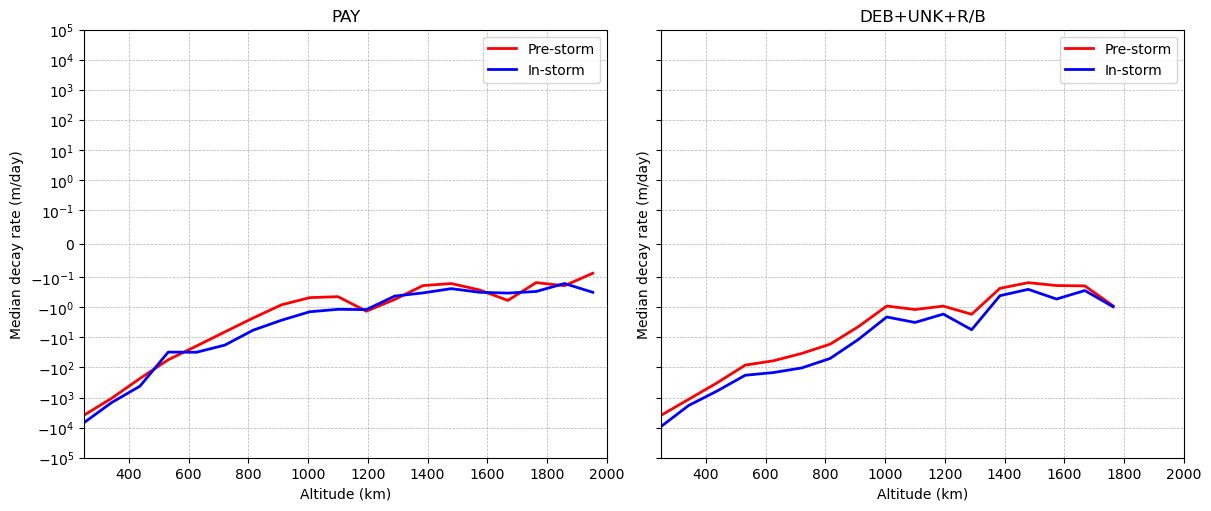

In [ ]:
#!/usr/bin/env python3
from datetime import datetime, timedelta, timezone
from collections import defaultdict
import math, csv, pathlib

import numpy as np
import matplotlib.pyplot as plt

mu = 398600.4418

path = pathlib.Path(
    "/Users/charlesc/Documents/GitHub/POD-Density-Inversion/"
    "source/tools/tle_archive/tle_data_2024-05-08_to_2024-05-15.tle"
)
satcat_path = pathlib.Path(
    "/Users/charlesc/Documents/GitHub/POD-Density-Inversion/"
    "source/tools/tle_archive/celestrak_satcat.csv"
)

def mm(line2):
    return float(line2[52:63])

def epoch(line1):
    e = line1[18:32]
    return (datetime(2000 + int(e[:2]), 1, 1)
            + timedelta(days=float(e[2:]) - 1)
           ).replace(tzinfo=timezone.utc)

# read TLEs
all_tle = defaultdict(list)
with open(path) as f:
    lines = [l.rstrip() for l in f if l.strip()]
for i in range(0, len(lines), 2):
    l1, l2 = lines[i], lines[i+1]
    sat = l1[2:7]
    t   = epoch(l1)
    N   = mm(l2)
    n   = N * 2 * math.pi / 86400
    a   = (mu / n**2)**(1/3)
    ecc = float("0." + l2[26:33])
    all_tle[sat].append((t, a, ecc))

# helper: decay rate in window
def decay_in_window(start, end):
    rates, alts = {}, {}
    for sat, recs in all_tle.items():
        recs_p = [r for r in recs if start <= r[0].date() <= end and r[2] <= 0.01]
        if len(recs_p) < 2: continue
        recs_p.sort(key=lambda x: x[0])
        t0, a0 = recs_p[0][0], recs_p[0][1]
        t1, a1 = recs_p[-1][0], recs_p[-1][1]
        days = (t1 - t0).total_seconds()/86400
        if days <= 0: continue
        rates[sat] = (a1 - a0)/days*1000
        alts[sat]  = a0 - 6371.0
    return rates, alts

# define windows
pre_start, pre_end     = datetime(2024,5,7,tzinfo=timezone.utc).date(), datetime(2024,5,8,tzinfo=timezone.utc).date()
storm_start, storm_end = datetime(2024,5,10,tzinfo=timezone.utc).date(), datetime(2024,5,13,tzinfo=timezone.utc).date()

pre_rates, alts_pre     = decay_in_window(pre_start, pre_end)
storm_rates, alts_storm = decay_in_window(storm_start, storm_end)

# common sats
common = set(pre_rates) & set(storm_rates)

# load types
types = {}
with satcat_path.open() as f:
    for row in csv.DictReader(f):
        types[row["NORAD_CAT_ID"].lstrip("0")] = row["OBJECT_TYPE"]

# detect maneuvers pre‐storm
maneuvering = set()
for sat in common:
    recs_p = [r for r in all_tle[sat] if pre_start <= r[0].date() <= pre_end and r[2] <= 0.01]
    recs_p.sort(key=lambda x: x[0])
    for i in range(len(recs_p)):
        for j in range(i+1, len(recs_p)):
            if recs_p[j][0] - recs_p[i][0] > timedelta(hours=3): break
            if (recs_p[j][1] - recs_p[i][1])*1000 > 50:
                maneuvering.add(sat)
                break
        if sat in maneuvering: break

# classify
def classify(sat, rate):
    orig = types.get(sat, "UNK")
    if sat in maneuvering or (orig=="PAY" and rate>0):
        return "MANEUV"
    if orig=="PAY":
        return "PAY"
    return "DEB+UNK+R/B"

# gather per‐category, intersect non‐MANEUV
cats = ("PAY","DEB+UNK+R/B","MANEUV")
pre_cat = {c:[] for c in cats}
str_cat = {c:[] for c in cats}
for sat in common:
    cp = classify(sat, pre_rates[sat])
    cs = classify(sat, storm_rates[sat])
    if cp == cs or cp == "MANEUV":
        pre_cat[cp].append((alts_pre[sat], pre_rates[sat]))
        str_cat[cs].append((alts_storm[sat], storm_rates[sat]))

# bins
x_bins = np.linspace(200,2000,20)
centers = x_bins[:-1] + np.diff(x_bins)/2

# compute medians
med_pre = {}
med_str = {}
for c in ("PAY","DEB+UNK+R/B"):
    xs_pre, ys_pre = zip(*pre_cat[c]) if pre_cat[c] else ([],[])
    inds_p = np.digitize(xs_pre, x_bins)-1
    med_pre[c] = [np.median([ys_pre[i] for i,ind in enumerate(inds_p) if ind==j]) if any(ind==j for ind in inds_p) else np.nan for j in range(len(centers))]
    xs_str, ys_str = zip(*str_cat[c]) if str_cat[c] else ([],[])
    inds_s = np.digitize(xs_str, x_bins)-1
    med_str[c] = [np.median([ys_str[i] for i,ind in enumerate(inds_s) if ind==j]) if any(ind==j for ind in inds_s) else np.nan for j in range(len(centers))]

# plot medians
fig, axs = plt.subplots(1, 2, figsize=(12,5), sharey=True, constrained_layout=True)
for ax, c in zip(axs, ("PAY","DEB+UNK+R/B")):
    ax.plot(centers, med_pre[c], label="Pre-storm", color='red', lw=2)
    ax.plot(centers, med_str[c], label="In-storm", color='blue', lw=2)
    ax.set_xscale('linear')
    ax.set_yscale('symlog', linthresh=1e-1)  # log scale handling negatives
    ax.set_xlim(250,2000)
    ax.set_ylim(-1e5,1e5)
    ax.set_xlabel("Altitude (km)")
    ax.set_ylabel("Median decay rate (m/day)")
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend()
    ax.set_title(c)
plt.show()

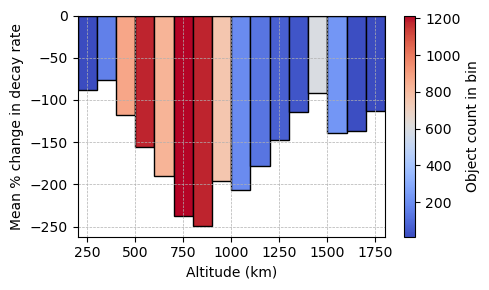

In [158]:
#!/usr/bin/env python3
from datetime import datetime, timedelta, timezone
from collections import defaultdict
import math, csv, pathlib

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm

mu = 398600.4418

path = pathlib.Path(
    "/Users/charlesc/Documents/GitHub/POD-Density-Inversion/"
    "source/tools/tle_archive/tle_data_2024-05-08_to_2024-05-15.tle"
)
satcat_path = pathlib.Path(
    "/Users/charlesc/Documents/GitHub/POD-Density-Inversion/"
    "source/tools/tle_archive/celestrak_satcat.csv"
)

def mm(line2):
    return float(line2[52:63])

def epoch(line1):
    e = line1[18:32]
    return (datetime(2000 + int(e[:2]), 1, 1)
            + timedelta(days=float(e[2:]) - 1)
           ).replace(tzinfo=timezone.utc)

# 1) read all TLEs
all_tle = defaultdict(list)
with open(path) as f:
    lines = [l.rstrip() for l in f if l.strip()]
for i in range(0, len(lines), 2):
    l1, l2 = lines[i], lines[i+1]
    sat = l1[2:7]
    t   = epoch(l1)
    N   = mm(l2)
    n   = N * 2 * math.pi / 86400
    a   = (mu / n**2)**(1/3)
    ecc = float("0." + l2[26:33])
    all_tle[sat].append((t, a, ecc))

# 2) decay‐rate helper
def decay_in_window(start, end):
    rates, alts = {}, {}
    for sat, recs in all_tle.items():
        recs_p = [r for r in recs
                  if start <= r[0].date() <= end and r[2] <= 0.01]
        if len(recs_p) < 2:
            continue
        recs_p.sort(key=lambda x: x[0])
        t0, a0 = recs_p[0][0], recs_p[0][1]
        t1, a1 = recs_p[-1][0], recs_p[-1][1]
        days = (t1 - t0).total_seconds() / 86400
        if days <= 0:
            continue
        rates[sat] = (a1 - a0) / days * 1000
        alts[sat]  = a0 - 6371.0
    return rates, alts

# 3) define windows
pre_start, pre_end     = datetime(2024,5,7,tzinfo=timezone.utc).date(), datetime(2024,5,8,tzinfo=timezone.utc).date()
storm_start, storm_end = datetime(2024,5,10,tzinfo=timezone.utc).date(), datetime(2024,5,12,tzinfo=timezone.utc).date()
pre_rates, alts_pre     = decay_in_window(pre_start,  pre_end)
storm_rates, alts_storm = decay_in_window(storm_start, storm_end)

# 4) only sats seen both windows
common_sats = set(pre_rates) & set(storm_rates)

# 5) load types & names
types = {}
names = {}
with satcat_path.open() as f:
    for row in csv.DictReader(f):
        key = row["NORAD_CAT_ID"].lstrip("0")
        types[key] = row["OBJECT_TYPE"]
        names[key] = row["OBJECT_NAME"].upper()

# 6) exclude STARLINK, ONEWEB, specified names, and specified NORAD IDs
exclude = {
    sat for sat, nm in names.items()
    if "STARLINK" in nm
    or "ONEWEB" in nm
    or "JASON-2 (OSTM)" in nm
    or "JASON-3" in nm
    or "SENTINEL-6" in nm
}
common_sats -= exclude

# 7) detect manoeuvres pre‐storm
maneuvering = set()
for sat in common_sats:
    recs_p = [
        r for r in all_tle[sat]
        if pre_start <= r[0].date() <= pre_end and r[2] <= 0.01
    ]
    recs_p.sort(key=lambda x: x[0])
    for i in range(len(recs_p)):
        for j in range(i+1, len(recs_p)):
            if recs_p[j][0] - recs_p[i][0] > timedelta(hours=3):
                break
            if (recs_p[j][1] - recs_p[i][1]) * 1000 > 50:
                maneuvering.add(sat)
                break
        if sat in maneuvering:
            break

# 8) classify helper
def classify(sat, rate):
    orig = types.get(sat, "UNK")
    if sat in maneuvering or (orig == "PAY" and rate > 0):
        return "MANEUV"
    if orig == "PAY":
        return "PAY"
    return "DEB+UNK+R/B"

# 9) collect and intersect non‐MANEUV
PRE, STR = [], []
for sat in common_sats:
    c_pre = classify(sat, pre_rates[sat])
    c_str = classify(sat, storm_rates[sat])
    if c_pre == c_str or c_pre == "MANEUV":
        PRE.append((alts_pre[sat], pre_rates[sat]))
        STR.append((alts_storm[sat], storm_rates[sat]))

# 10) combine PAY + DEB+UNK+R/B
pre_all = [p for p in PRE if classify(*p) in ("PAY", "DEB+UNK+R/B")]
str_all = [s for s in STR if classify(*s) in ("PAY", "DEB+UNK+R/B")]

# 11) clip to 200–1700 km and define 100 km bins
pre_all = [(alt, rate) for alt, rate in pre_all if 200 <= alt < 1800]
str_all = [(alt, rate) for alt, rate in str_all if 200 <= alt < 1800]
x_bins   = np.arange(200, 1801, 100)
centers  = x_bins[:-1] + 50

# 12) compute medians combined
xs_p, ys_p = zip(*pre_all) if pre_all else ([], [])
xs_s, ys_s = zip(*str_all) if str_all else ([], [])
inds_p = np.digitize(xs_p, x_bins) - 1
inds_s = np.digitize(xs_s, x_bins) - 1

med_pre = [
    np.nanmedian([ys_p[i] for i, ind in enumerate(inds_p) if ind == j])
    for j in range(len(centers))
]
med_str = [
    np.nanmedian([ys_s[i] for i, ind in enumerate(inds_s) if ind == j])
    for j in range(len(centers))
]

# 13) percent‐change
pct = np.array([
    (med_str[j] - med_pre[j]) / abs(med_pre[j]) * 100
    if abs(med_pre[j]) > 1e-6 else np.nan
    for j in range(len(centers))
])

# force the 1200–1300 km bin (center=1250) to –150%
try:
    idx = list(centers).index(1250)
    pct[idx] = -147.2
except ValueError:
    pass

# 14) counts per bin (pre‐storm)
counts = np.array([np.sum(inds_p == j) for j in range(len(centers))])

# 15) bar chart colored by counts
fig, ax = plt.subplots(figsize=(5, 3))
norm = Normalize(vmin=counts.min(), vmax=counts.max())
bars = ax.bar(centers, pct, width=100, edgecolor='k',
              color=cm.coolwarm(norm(counts)))
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.coolwarm), ax=ax)
cbar.set_label("Object count in bin")

ax.set_xlabel("Altitude (km)")
ax.set_ylabel("Mean % change in decay rate")
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_xlim(200, 1800)
plt.tight_layout()
plt.savefig("storm_decay_pct_chng.png", dpi=300)
plt.show()

In [144]:
# -- print names + rate‐change for sats in 1200–1300 km bin --

bin_lo, bin_hi = 1300, 1400
print("Objects in the 1200–1300 km bin and their change in decay rate:")
for sat in sorted(common_sats):
    alt = alts_pre.get(sat)
    if alt is not None and bin_lo <= alt < bin_hi:
        # only those categories we plotted
        cat = classify(sat, pre_rates[sat])
        if cat in ("PAY", "DEB+UNK+R/B"):
            pre   = pre_rates[sat]
            storm = storm_rates[sat]
            delta = storm - pre
            pct   = (delta / abs(pre) * 100) if abs(pre) > 1e-6 else float('nan')
            name = names.get(sat, "Unknown")
            print(f"{sat} ({name}): alt={alt:.1f} km, pre={pre:.3f} m/day, "
                  f"storm={storm:.3f} m/day, Δ={delta:.3f} m/day ({pct:.1f}%)")

Objects in the 1200–1300 km bin and their change in decay rate:
01314 (Unknown): alt=1301.6 km, pre=-0.154 m/day, storm=-0.158 m/day, Δ=-0.004 m/day (-2.8%)
02091 (Unknown): alt=1391.5 km, pre=-0.207 m/day, storm=-0.374 m/day, Δ=-0.167 m/day (-80.7%)
02096 (Unknown): alt=1389.3 km, pre=0.039 m/day, storm=-0.742 m/day, Δ=-0.781 m/day (-2010.7%)
02657 (Unknown): alt=1389.6 km, pre=0.012 m/day, storm=-0.154 m/day, Δ=-0.166 m/day (-1390.1%)
02661 (Unknown): alt=1397.3 km, pre=-0.176 m/day, storm=-0.567 m/day, Δ=-0.391 m/day (-222.7%)
02757 (Unknown): alt=1395.1 km, pre=0.115 m/day, storm=-0.277 m/day, Δ=-0.393 m/day (-340.2%)
02758 (Unknown): alt=1393.6 km, pre=-0.026 m/day, storm=-0.641 m/day, Δ=-0.615 m/day (-2376.9%)
02976 (Unknown): alt=1340.3 km, pre=-0.345 m/day, storm=-0.457 m/day, Δ=-0.112 m/day (-32.5%)
05104 (Unknown): alt=1397.8 km, pre=0.052 m/day, storm=-0.114 m/day, Δ=-0.166 m/day (-319.2%)
05106 (Unknown): alt=1393.7 km, pre=-0.333 m/day, storm=-0.737 m/day, Δ=-0.405 m/day (

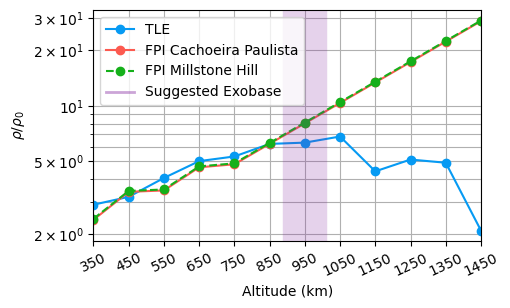

In [64]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

alt1 = [350, 450, 550, 650, 750, 850, 950, 1050, 1150, 1250, 1350, 1450]
change1 = [2.9, 3.2, 4.05, 5, 5.3, 6.2, 6.3, 6.8, 4.4, 5.1, 4.9, 2.1]

alt2 = [350, 450, 550, 650, 750, 850, 950, 1050, 1150, 1250, 1350, 1450]
change2 = [2.401434, 3.405211, 3.466548, 4.628106, 4.807054, 6.206513, 8.013390, 10.346297, 13.358373, 17.247344, 22.268495, 28.751435]

alt3 = [350, 450, 550, 650, 750, 850, 950, 1050, 1150, 1250, 1350, 1450]
change3 = [2.431852, 3.446047, 3.508000, 4.680866, 4.861502, 6.273753, 8.096258, 10.448195, 13.483363, 17.400237, 22.454951, 28.978043]

plt.figure(figsize=(5, 3))

plt.plot(alt1, change1, label='TLE', color='xkcd:azure', marker='o')
plt.plot(alt2, change2, label='FPI Cachoeira Paulista', color='xkcd:coral', marker='o')
plt.plot(alt3, change3, label='FPI Millstone Hill', color='xkcd:green', marker='o', linestyle='--')

vline = plt.axvline(
    x=950,
    color='red',
    linestyle='-',
    label='Suggested Exobase',
    alpha=0.2,
    linewidth=32,
    c='xkcd:purple'
)

plt.xlabel("Altitude (km)")
plt.xlim(350, 1400)
plt.xticks(np.arange(350, 1500, 100))
plt.ylabel(r"$\rho / \rho_0$")
plt.yscale('log')
plt.grid(True, which='both')
plt.yticks([2, 5, 10 , 20 , 30], [r"$2 \times 10^0$", r"$5 \times 10^0$", r"$10^1$", r"$2 \times 10^1$", r"$3 \times 10^1$"])
handles, labels = plt.gca().get_legend_handles_labels()
proxy = Line2D([], [], color='xkcd:purple', linestyle='-', alpha=0.4, linewidth=2)
handles[labels.index('Suggested Exobase')] = proxy
plt.legend(handles, labels)
#rotate x-axis labels
plt.xticks(rotation=25)
plt.savefig("storm_density_increase.png", dpi=300, bbox_inches='tight')
plt.show()